In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ursse.phase_space_trajectory as pst
import ursse_cpp.sync_motion_sim as sm
from config_ursse import get_from_config, save_to_config
from ursse.path_assistant import PathAssistant
import os
images_dir = os.path.join(get_from_config("URSSE_sync_motion_note_dir"),
                          "images")
shift = PathAssistant('shift_02_28_2020')
np_rand_seed = 1

## Remeber for repeatable resuts you need to set numpy random seed

In [2]:
gamma = get_from_config("gamma")
alpha = get_from_config("ring_alpha")
V = get_from_config("Vrf")
f = 1/get_from_config("IOTA_revolution_period")
h = get_from_config("RF_q")
c = get_from_config("c_m/s")
rho= get_from_config("dipole_rho_m")
D = alpha*(1/f*c/2/np.pi)/rho

In [3]:
# save_to_config("damping_partition_JE", 2+D)

In [4]:
JE = get_from_config("damping_partition_JE")

In [5]:
hbar_c = 0.1973269804e-6
gamma_to_nav = 0.0661969
Ec = 3 / 2 * hbar_c * pow(gamma, 3) / rho
nav = gamma_to_nav*gamma
save_to_config("nav", nav)
save_to_config("Ec", Ec)

In [6]:
nav

12.48802575342958

# Textbook results for  rms bunch length

In [7]:
E0 = gamma*511000
v0 = V/E0
eta = alpha - 1/gamma**2
w = 2*np.pi*h*eta
delta_rms = 0.62e-6*gamma/np.sqrt(JE*rho)
print("delta rms = ", delta_rms)
tau_rms = 1e9*delta_rms/((f*h)*2*np.pi*np.sqrt(V/(2*np.pi*E0*h*np.abs(eta))))
print("tau_rms = ", tau_rms, "ns")

delta rms =  8.597426389751137e-05
tau_rms =  0.30651267688936373 ns


# Energy per turn distribution

Number of emitted photons is obtained from Poisson distribution, then the energy of each photon is obtained from InvSynchFractInt, then their sum is calculated


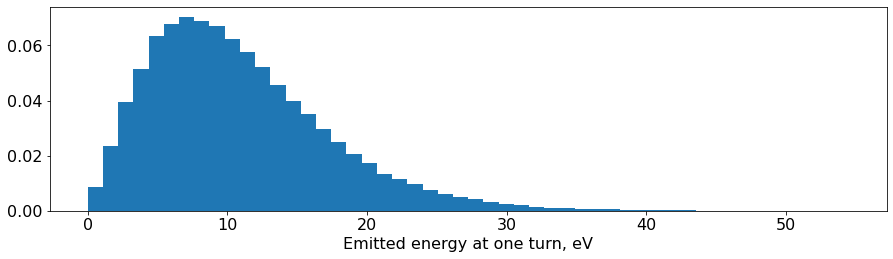

In [8]:
nrev = 100000
np.random.seed(np_rand_seed)
nphs = np.random.poisson(lam=nav, size=nrev)
ens = np.zeros(nrev)
for i,nph in enumerate(nphs):
    ens[i] = sum([sm.InvSynchFractInt(r) for r in np.random.rand(nph)])*Ec
plt.hist(ens, bins=50, density=True)
plt.xlabel("Emitted energy at one turn, eV")
print("Number of emitted photons is obtained from Poisson distribution,"
     " then the energy of each photon is obtained from InvSynchFractInt,"
     " then their sum is calculated")
plt.show()

In [9]:
Eav = np.mean(ens)
Eav

10.901362958283459

In [10]:
Estd = np.std(ens)
Estd

6.416587254284234

In [11]:
M = 1/(Estd/Eav)**2
M

2.886379229458743

In [12]:
k = M
theta = Eav/M
k, theta

(2.886379229458743, 3.7768297550865118)

In [13]:
# save_to_config("M", M)

# Comparison of Gamma distribution with the simulated one

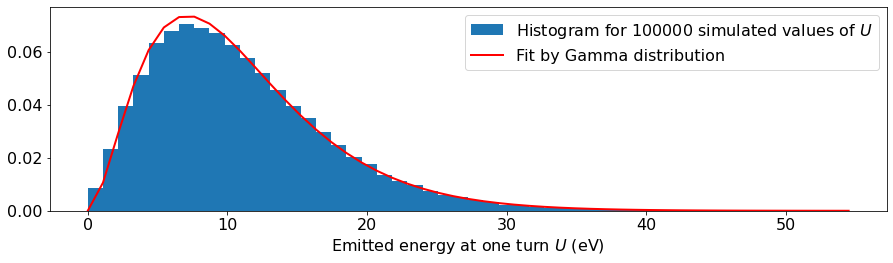

In [14]:
shape, scale = k, theta  # mean=4, std=2*sqrt(2)
nrolls = 100000
np.random.seed(np_rand_seed)
s = np.random.gamma(shape, scale, nrolls)
import scipy.special as sps 
fig, ax = plt.subplots()
count, bins, ignored = ax.hist(ens, bins=50, density=True,
        label=f'Histogram for {nrolls} simulated values of ' + r'$U$')
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
ax.plot(bins, y, linewidth=2, color='r', label='Fit by Gamma distribution')  
# plt.hist(sm.RandomEnergyGammaDistribution(k, theta, nrolls, 42),
#          bins=50, density=True,
#          label='From C++ - random variable with Gamma distribution')
ax.set_xlabel(r"Emitted energy at one turn $U$ (eV)")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
fig.savefig(os.path.join(images_dir,
                             "energy_per_turn_distribution.png"),
            dpi=300, bbox_inches='tight')
plt.show()

# Distribution for a single emitted photon

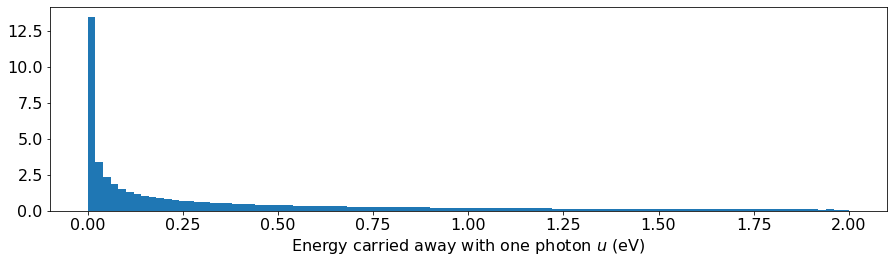

In [15]:
rands = np.random.rand(1000000)
en = np.zeros(shape=rands.shape)
Et = 8/9*np.pi*1/137*gamma*Ec
Scale = 15*np.sqrt(3)/8*Et
for i,r in enumerate(rands):
    en[i] = sm.InvSynchFractInt(r)*Ec
plt.hist(en, bins=100, range=(0,2.0),density=True)
plt.xlabel(r"Energy carried away with one photon $u$ (eV)")
plt.savefig(os.path.join(images_dir,
                             "one_photon_energy_density_function.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [16]:
2*E0/JE/Et/f

0.8906438729123501

In [17]:
Et

10.91643937761682

In [18]:
Eav

10.901362958283459

In [19]:
save_to_config("Et", Et)

In [20]:
phis = np.arcsin(Et/V)
save_to_config("phis", phis)

In [21]:
np.mean(en)

0.8731191986685451

In [22]:
np.std(en)

1.5869383847528336

# Simulation for 60 seconds

In [23]:
meas_df = pst.get_revolution_delay_df_one_gate(
    'shift_02_28_2020', '1el_002.ptu')

In [ ]:
%%time
sim_df = sm.get_simulated_revolution_delay_data(
    gamma, alpha, V, f, h, JE, k, theta,
    meas_df['revolution'],
    tau0=tau_rms, delta0=0, rand_seed_int=3, rf_noise_std=7e-5)
sim_df.to_pickle(shift.get_results_dir().fi("sim_df.pkl"))

In [24]:
sim_df = pd.read_pickle(shift.get_results_dir().fi("sim_df.pkl"))

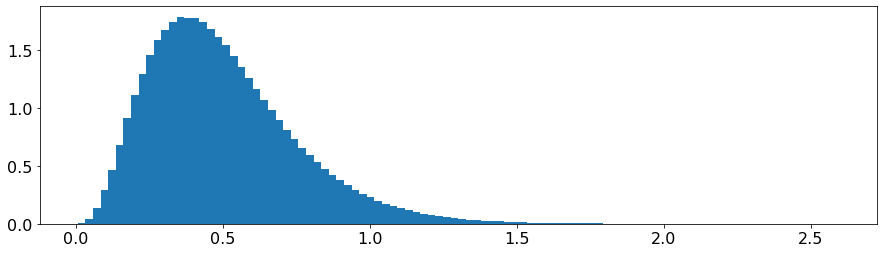

In [25]:
# adding random gamma to sim_df to simulate spad's tts
spad_tts = 0.25
mean_spad = 0.5
std_spad = spad_tts
theta_spad = std_spad**2/mean_spad
k_spad = mean_spad/theta_spad
ts_spad = np.random.gamma(k_spad, theta_spad, size=len(sim_df.index))
fig, ax = plt.subplots(figsize=(15,4))
ax.hist(ts_spad, bins=100, density=True)
plt.show()
sim_df['delay'] = sim_df['delay'] + ts_spad

In [26]:
print(f"Simulation rms bunch length = {sim_df.delay.std():.3f} ns")
print(f"Textbook equation rms bunch length = {tau_rms:.3f} ns")

Simulation rms bunch length = 0.579 ns
Textbook equation rms bunch length = 0.307 ns


# Comparison of simulation and measurement

In [27]:
sim_T0 = pst.get_initial_sync_period_estimate(sim_df)
sim_phase_df, sim_fits_df = pst.get_phase_df_from_revoluton_delay_df(sim_df, sim_T0)
sim_sz_df = pst.get_sz_df(sim_df, spad_tts_ns=0)
sim_polar_df = pst.get_polar_df(sim_phase_df, sim_sz_df)

In [28]:
meas_T0 = pst.get_initial_sync_period_estimate(meas_df)
spad_tts = 0.35
meas_phase_df, meas_fits_df = pst.get_phase_df_from_revoluton_delay_df(meas_df, meas_T0)
meas_sz_df = pst.get_sz_df(meas_df, spad_tts_ns=0)
meas_polar_df = pst.get_polar_df(meas_phase_df, meas_sz_df)

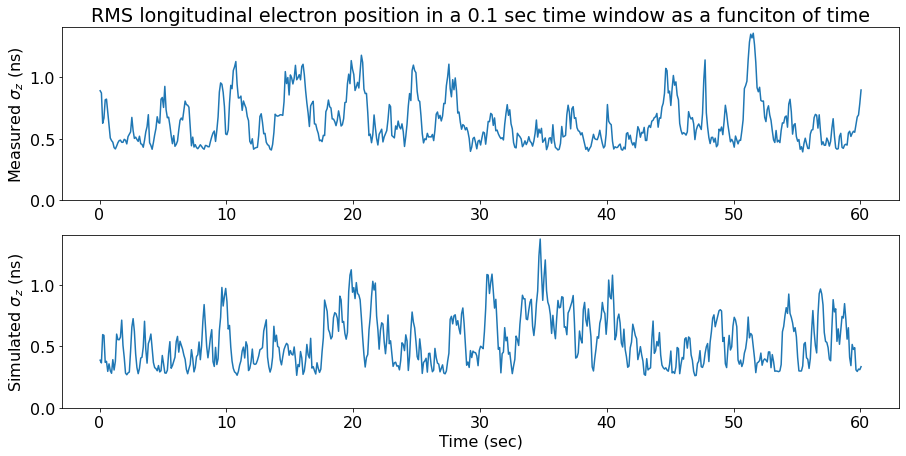

In [29]:
fig, ax = plt.subplots(2, figsize=(15,7))
ax[0].plot(meas_sz_df['time_sec'], meas_sz_df['sz_ns'])
ax[0].set_ylim(0,ax[0].get_ylim()[1])
ax[0].set_ylabel("Measured $\sigma_z$ (ns)")
ax[1].set_xlabel("Time (sec)")
ax[1].plot(sim_sz_df['time_sec'], sim_sz_df['sz_ns'])
ax[1].set_ylim(0,ax[1].get_ylim()[1])
ax[1].set_ylabel("Simulated $\sigma_z$ (ns)")
ax[1].set_ylim(ax[0].get_ylim())
ax[0].set_title("RMS longitudinal electron position in a 0.1 sec time window"
                " as a funciton of time")
fig.savefig(os.path.join(images_dir,
                             "comparison_of_rms_vs_time.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [30]:
np.sqrt(meas_df.delay.std()**2-spad_tts**2)

0.557154974838618

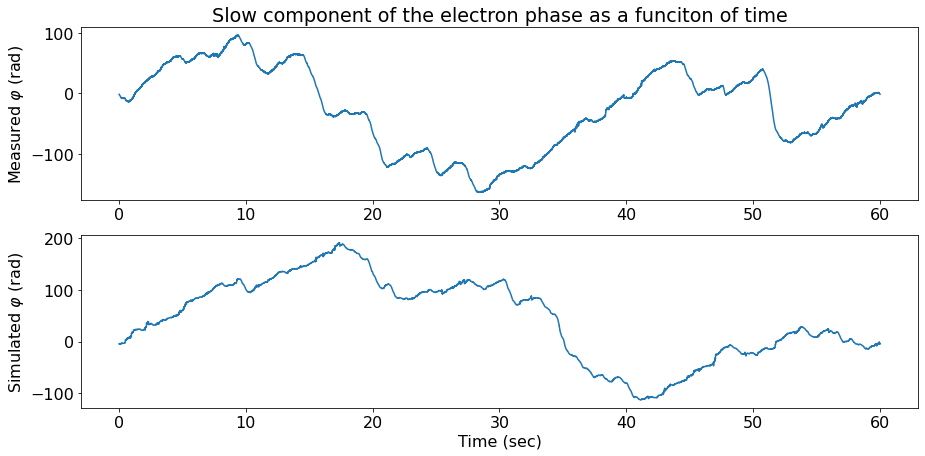

In [31]:
fig, ax = plt.subplots(2, figsize=(15,7))
ax[0].plot(meas_phase_df['time_sec'], meas_phase_df['phase_rad'])
ax[0].set_ylabel(r"Measured $\varphi$ (rad)")
ax[1].set_xlabel("Time (sec)")
ax[1].plot(sim_phase_df['time_sec'], sim_phase_df['phase_rad'])
ax[1].set_ylabel(r"Simulated $\varphi$ (rad)")
ax[0].set_title("Slow component of the electron phase as a funciton of time")
fig.savefig(os.path.join(images_dir,
                             "comparison_of_phase_vs_time.png"),
            dpi=300, bbox_inches='tight')
plt.show()

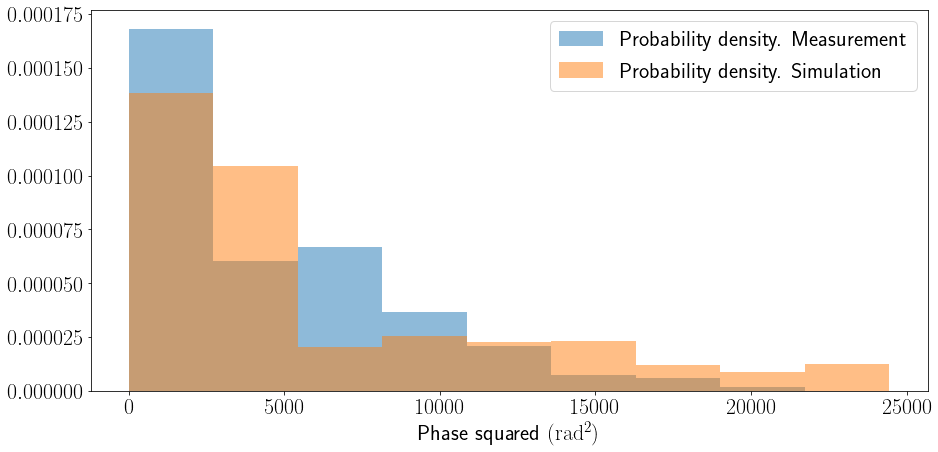

In [34]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(30,8),
                     'font.size': 22,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
nbins = 10
amps_tuple = [(df['phase_rad'].values-df['phase_rad'].mean())**2 for df in (meas_phase_df, sim_phase_df)]
all_amps = np.concatenate(amps_tuple)
l = np.min(all_amps)
r = np.max(all_amps)
bins = np.linspace(l, r, nbins)
bin_centers = (bins[1:]+bins[:-1])/2
kick_hists = [np.histogram(amps, bins=bins)[0] 
                  for amps in amps_tuple]
fig, ax = plt.subplots(figsize=(15,7))
ax.hist(bin_centers, weights=kick_hists[0], bins=bins, density=True,
            alpha=0.5, label="Probability density. Measurement")
ax.hist(bin_centers, weights=kick_hists[1], bins=bins, density=True,
            alpha=0.5, label="Probability density. Simulation")
ax.set_xlabel(r"Phase squared $(\SI{}{rad^2})$")
ax.legend()
plt.show()

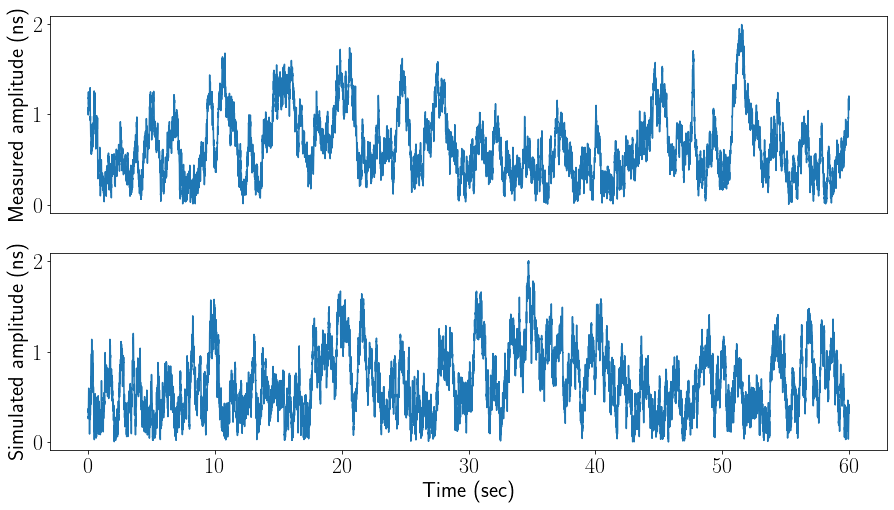

In [33]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(30,8),
                     'font.size': 22,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fig, axs = plt.subplots(2, figsize=(15,8))
axs[0].plot(meas_fits_df['mid_time_sec'], meas_fits_df['Amplitude_ns'])
axs[0].set_xticks([])
axs[1].plot(sim_fits_df['mid_time_sec'], sim_fits_df['Amplitude_ns'])
axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_xlabel(r"Time (sec)")
axs[0].set_ylabel("Measured amplitude (ns)")
axs[1].set_ylabel("Simulated amplitude (ns)")
plt.show()

In [34]:
for df in [meas_fits_df, sim_fits_df]:
    print(np.sqrt(df['Amp2'].mean()/2))

0.5260762176108879
0.5239695639529831


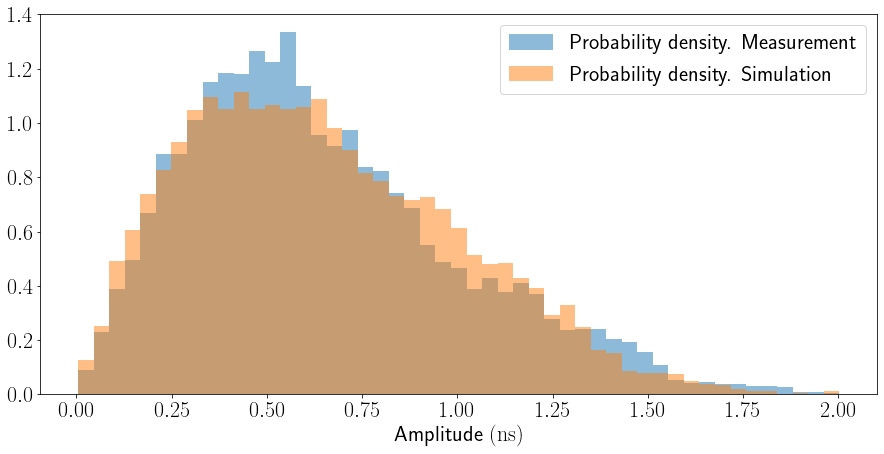

In [35]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(30,8),
                     'font.size': 22,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
nbins = 50
amps_tuple = [df['Amplitude_ns'].values for df in (meas_fits_df, sim_fits_df)]
all_amps = np.concatenate(amps_tuple)
l = np.min(all_amps)
r = np.max(all_amps)
bins = np.linspace(l, r, nbins)
bin_centers = (bins[1:]+bins[:-1])/2
kick_hists = [np.histogram(amps, bins=bins)[0] 
                  for amps in amps_tuple]
fig, ax = plt.subplots(figsize=(15,7))
ax.hist(bin_centers, weights=kick_hists[0], bins=bins, density=True,
            alpha=0.5, label="Probability density. Measurement")
ax.hist(bin_centers, weights=kick_hists[1], bins=bins, density=True,
            alpha=0.5, label="Probability density. Simulation")
ax.set_xlabel(r"Amplitude $(\SI{}{ns})$")
ax.legend()
plt.show()

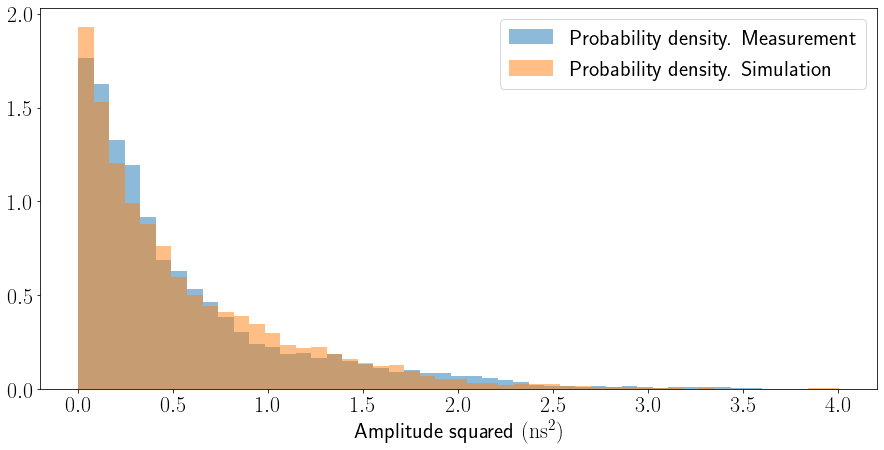

In [36]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(30,8),
                     'font.size': 22,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
nbins = 50
amps_tuple = [df['Amp2'].values for df in (meas_fits_df, sim_fits_df)]
all_amps = np.concatenate(amps_tuple)
l = np.min(all_amps)
r = np.max(all_amps)
bins = np.linspace(l, r, nbins)
bin_centers = (bins[1:]+bins[:-1])/2
kick_hists = [np.histogram(amps, bins=bins)[0] 
                  for amps in amps_tuple]
fig, ax = plt.subplots(figsize=(15,7))
ax.hist(bin_centers, weights=kick_hists[0], bins=bins, density=True,
            alpha=0.5, label="Probability density. Measurement")
ax.hist(bin_centers, weights=kick_hists[1], bins=bins, density=True,
            alpha=0.5, label="Probability density. Simulation")
ax.set_xlabel(r"Amplitude squared $(\SI{}{ns^2})$")
ax.legend()
plt.show()

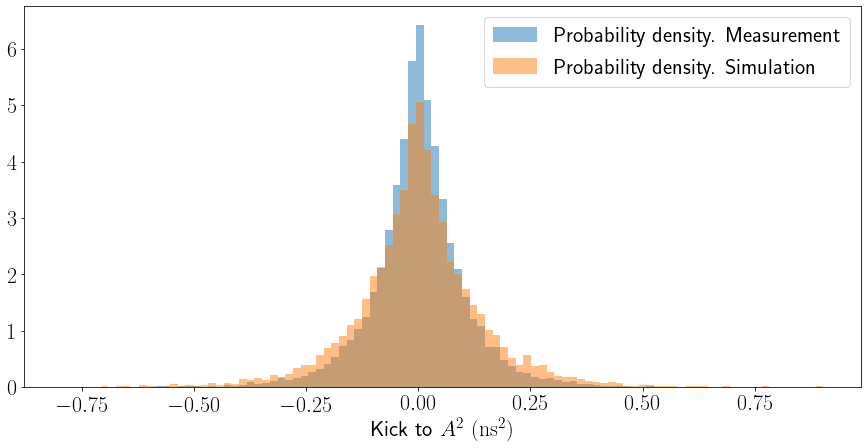

In [37]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(30,8),
                     'font.size': 22,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
nbins = 100
kicks_tuple = [df['Kicks'].values for df in (meas_fits_df, sim_fits_df)]
all_kicks = np.concatenate(kicks_tuple)
l = np.min(all_kicks)
r = np.max(all_kicks)
bins = np.linspace(l, r, nbins)
bin_centers = (bins[1:]+bins[:-1])/2
kick_hists = [np.histogram(kicks, bins=bins)[0] 
                  for kicks in kicks_tuple]
fig, ax = plt.subplots(figsize=(15,7))
ax.hist(bin_centers, weights=kick_hists[0], bins=bins, density=True,
            alpha=0.5, label="Probability density. Measurement")
ax.hist(bin_centers, weights=kick_hists[1], bins=bins, density=True,
            alpha=0.5, label="Probability density. Simulation")
ax.set_xlabel(r"Kick to $A^2$ $(\SI{}{ns^2})$")
ax.legend()
plt.show()